In [15]:
%matplotlib notebook
# %matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
import math

### Kernels and their derivatives w.r.t parameters

In [16]:
def sqexp(x, xp, params):#tau1=1.0,tau2 = 1.0, l1=3.0, l2=2.0):
    """Squared exponential kernel (1 dimensional)
    
    Inputs
    ------
    x : (N), array of multiple inputs
    xp: float
    
    Returns
    -------
    cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    tau = params[0]
    l1 = params[1]
    l2 = params[2]
    Q = np.diag([1/l1,1/l2])
    cov = tau**2 * np.exp(-1/2 * (x-xp).T @ Q @ (x-xp))
    return cov

def sqexp_grad(x,xp,params):
    tau = params[0]
    l1 = params[1]
    l2 = params[2]    
    Q = np.diag([1/l1,1/l2])
    
    dcov_dtau = 2 * tau * np.exp(-1/2 * (x-xp).T @ Q @ (x-xp))
    
    dQ_dl1 = np.diag([-1/l1/l1,0])
    dcov_dl1 = tau**2 * np.exp(-1/2 * (x-xp).T @ dQ_dl1 @ (x-xp))
    
    dQ_dl2 = np.diag([0,-1/l2/l2])
    dcov_dl2 = tau**2 * np.exp(-1/2 * (x-xp).T @ dQ_dl2 @ (x-xp))
    
    return [dcov_dtau, dcov_dl1, dcov_dl2]


Periodic kernel:

In [17]:
def periodic(x, xp, params):#tau=1, l=1.0, p=0.4): # exp sin squared kernel
    """Periodic kernel"""
    tau = params[0]; l = params[1]; p = params[2];
    return tau**2 * np.exp ( -2 * np.sin(np.pi * np.linalg.norm(x - xp) / p )**2 / l**2)

def periodic_grad(x, xp, params):
    tau = params[0]; l = params[1]; p = params[2];
    power_coeff = -2 * np.sin(np.pi * np.linalg.norm(x - xp) / p )**2 / l**2
    trig_coeff = np.pi * np.linalg.norm(x - xp) / p
    
    dcov_dtau = 2 * tau * np.exp ( power_coeff)    
    dcov_dl = tau**2 * np.exp ( power_coeff ) * power_coeff * (l**2) * (-2/l**3)    
    dcov_dp = tau**2 * np.exp ( power_coeff ) * (-2/l**2) * ( 2*np.sin(trig_coeff)*np.cos(trig_coeff) ) * ( np.pi * np.linalg.norm(x-xp) ) * (-1/p**2)
    return [dcov_dtau, dcov_dl, dcov_dp]

In [18]:
## Rational Quadratic
def rational(x, xp, params):
    sigma = params[0]
    alpha = params[1]
    l = params[2]
    return sigma**2 * ( 1 + 1/2/alpha/l**2 * np.linalg.norm(x-xp) )**(-alpha)

def rational_grad(x, xp, params):
    sigma = params[0]
    alpha = params[1]
    l = params[2]
    dist = np.linalg.norm(x-xp)
    
    dcov_dsigma = 2*sigma ** ( 1 + 1/2/alpha/l**2 * dist )**(-alpha)
    dcov_dalpha = sigma**2 *  (1 + 1/2/alpha/l**2 * dist )**(-alpha) * ( -np.log( 1 + 1/2/alpha/l**2 * dist ) + dist/2/alpha/l**2 / (1 + 1/2/alpha/l**2 * dist)  )
    dcov_dl = sigma**2 * dist / l**3 * (1 + 1/2/alpha/l**2 * dist)**(-1-alpha)
    return [dcov_dsigma, dcov_dalpha, dcov_dl]

# aa = np.array([1,1])
# bb = np.array([2,2])
# rational_grad(aa,bb,[0.77048938, 1.42069278, 1.0])

Polynomial kernel: TO DEBUG (not using right now)

In [19]:
KERNELS = {"SqExp":sqexp, "Rational":rational, "Periodic":periodic}
KERNEL_PARAMS = {"SqExp":[1.0,3.0, 2.0], "Rational":[1.0, 1.0, 1.0], "Periodic":[1.0, 1.0, 1.0]}

In [20]:
# def poly(x, xp, params):
#     """Polynomial kernel"""
#     c = params[0]; d = params[1];
#     print("poly: ",x.T @ xp + c)
#     return (np.abs(x.T @ xp) + c)**d

# def poly_grad(x, xp, params):
#     c = params[0]; d = params[1];
#     dcov_dc = d * (x.T @ xp+c)**(d-1)
#     dcov_dd = (np.abs(x.T @ xp) + c)**d * np.log((np.abs(x.T @ xp)+c))
#     return [dcov_dc, dcov_dd]

# aa = np.array([1,1])
# bb = np.array([2,2])
# poly(aa,bb,[0.77048938, 1.42069278])

### Build Covariance matrix and its derivatives

In [21]:
def build_covariance(x, xp, kern, params):
    """Build a covariance matrix
    
    Inputs
    -------
    x: (N) array of inputs
    xp: (M) array of inptus
    kern: a function mapping inputs to covariance
    
    Outputs
    -------
    cov: (N, M) covariance matrix
    """
    out = np.zeros((x.shape[0], xp.shape[0]))
    for jj in range(xp.shape[0]):
        for ii in range(x.shape[0]):
            value = kern(x[ii], xp[jj], params)
            out[ii, jj] = value
    return out

def build_covariance_gradient(x, xp, kern, params):
    num_params = np.shape(params)[0]
    out = np.zeros((x.shape[0], xp.shape[0],num_params))
    der = globals()[kern.__name__+'_grad']
    for jj in range(xp.shape[0]):
        for ii in range(x.shape[0]):
            value = der(x[ii], xp[jj], params)
            out[ii, jj, :] = value
    return out

### Function for predicting value at new point

Rational quadratic kernel

In [22]:
def gpr(xtrain, ytrain, xpred, noise_var, mean_func, kernel, params = None):
    """Gaussian process regression Algorithm

    Inputs
    -------
    xtrain: (N, ) training inputs
    ytrain: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    kernel: covariance kernel
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    
    cov = build_covariance(xtrain, xtrain, kernel, params)
#     print(cov)
    u, s, v = np.linalg.svd(cov)
    sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noise_var))
    
    vec_pred = build_covariance(xpred, xtrain, kernel, params)
#     print(vec_pred)

    pred_mean = mean_func(xpred) + vec_pred @ invcov @ (ytrain - mean_func(xtrain))
    
    cov_predict_pre = build_covariance(xpred, xpred, kernel, params)
    cov_predict_up = vec_pred @ invcov @ vec_pred.T
    pred_cov = cov_predict_pre - cov_predict_up
    
    # Sometimes the values are small negaive, example -1e-5, just make them 0. probably due to inaccurate matrix inversion operations
    pred_cov[ pred_cov < 0 ] = 0
    
    return pred_mean, pred_cov

# mean, cov = gpr(train_input_0, train_output_0, pred_input, noise_cov * np.ones((train_input_0.shape[0])), mean_func, periodic, [1.0, 1.0, 1.0])
# print(mean)

In [23]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
# Minimize negative log likelihood for hyparameter optimization

def negative_log_likelihood(kernel, params, train_x1, train_x2, ytrain):
    
    xtrain = np.concatenate((train_x1.reshape(-1,1),train_x2.reshape(-1,1)),axis=1)
    cov = build_covariance(xtrain, xtrain, kernel, params)
    n = np.shape(cov)[0]  # assuming a square matrix
    noise_var = 0.001
    # mean function in lecture notebooks is directly taken as 0 in subsequent code
    det_cov = np.linalg.det(cov + noise_var*np.eye(n))
    if det_cov<0: 
        det_cov = 0.001
    if det_cov<-0.1:
        print("ERROR")
    log_likelihood = -1/2*( ytrain - np.zeros((xtrain.shape[0],1)) ).T @ np.linalg.inv(cov + noise_var*np.eye(n)) @ ( ytrain - np.zeros((xtrain.shape[0],1))) - 1/2*np.log( det_cov ) - n/2*np.log(2*np.pi)
    return -log_likelihood[0,0]

def negative_log_likelihood_gradient(kernel, params, train_x1, train_x2, ytrain):

    xtrain = np.concatenate((train_x1.reshape(-1,1),train_x2.reshape(-1,1)),axis=1)
    cov = build_covariance(xtrain, xtrain, kernel, params)
    dK = build_covariance_gradient(xtrain, xtrain, kernel, params)
    
    n = np.shape(cov)[0]  # assuming a square matrix
    noise_var = 0.001
    K_inv = np.linalg.inv(cov + noise_var*np.eye(n))
    
    log_grads = []
    for i in range(np.shape(params)[0]):
        dL = 1/2*ytrain.T @ K_inv @ dK[:,:,i] @ K_inv @ ytrain - 1/2* np.trace( K_inv @ dK[:,:,i] )
        log_grads.append(dL[0,0])
    
    return -np.array(log_grads)

def train_gp(train_x1, train_x2, ytrain):
    negative_log_likelihoods = []
    original_negative_log_likelihoods = []
    params = []
    names = []
    for idx, kernel_name in enumerate(KERNELS):
        
        kernel = KERNELS[kernel_name]
        kernel_params = np.copy(KERNEL_PARAMS[kernel_name])
        names.append(kernel)
        
        print(f"optimizing kernel : {kernel.__name__}, initial parameter :{kernel_params}")
        
        min_function = lambda x: negative_log_likelihood(kernel, x, train_x1, train_x2, ytrain)
        min_function_grad = lambda x: negative_log_likelihood_gradient(kernel, x, train_x1, train_x2, ytrain)
        
        original_negative_log_likelihoods.append( min_function(kernel_params) )
        
        if np.shape(kernel_params)[0]==2:
            bounds = Bounds([0, 0], [100.0, 100])
        else:
            bounds = Bounds([0, 0, 0], [100.0, 100, 100])
        res = minimize_(1000, min_function, kernel_params, jac=min_function_grad)
        negative_log_likelihoods.append( min_function(res) )
        params.append(res)    
        print("Optimized parameter for this kernel: ",res)
        print("\n")
    
    print("ALL kernel optimization finished \n")
    print("Original parameter (negative)likelihoods for all kernels ",original_negative_log_likelihoods )
    print("Optimized parameter (negative)likelihoods for all kernels", negative_log_likelihoods)
    print("\n Make sure that NEW PARAMETERS (negative) likelihood < OLD PARAMETER (negative) likelihood")

    return names, params

def clip_to_max(value, max_value):
    if value>max_value:
        return max_value
    if value<-max_value:
        return -max_value
    return value

# Minimize function based on gradient descent
def minimize_(max_iter, min_function, param, jac):
    iters = 0
    
    # Update only 1 parameter at a time. choose how frequently to change this
    alter_id = 2
    mode = 0 # specifies which parameter to change
    
    # Gradient descent parameters
    grad_max = 50;
    rate = 0.005
    
    # initialize system
    cur_param = param
    num_params = np.shape(param)[0]
    
    # parameter lower tolerance (we need all parameters to be >0 for kernel)
    eps = 0.00005
    
    while iters < max_iter:
        prev_param = cur_param
        
        # update GD update rate
        if (iters == 600):
            rate = 0.0003
        elif (iters == 800):
            rate = 0.0002
        
        L = min_function(cur_param)
        dL_dparam = jac(cur_param)
        dL_dparam[mode] = clip_to_max(dL_dparam[mode], grad_max)
        cur_param[mode] = cur_param[mode] - rate * dL_dparam[mode]
        if cur_param[mode]<eps:
            cur_param[mode] = eps;     
        if np.any(np.isnan(cur_param)==True):            
            print("found nan", cur_param)
            
        iters = iters + 1
        
        if iters % alter_id == 0:
            mode = mode + 1
            if mode >= num_params:
                mode = 0
    return cur_param
                
# train_gp(train_x_0, train_y_0, train_output_0)

## Process given data 0

In [60]:
train_x_0 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9])
train_y_0 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9])
train_output_0 = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616]).reshape(-1,1);
train_input_0 = np.concatenate((train_x_0.reshape(-1,1),train_y_0.reshape(-1,1)),axis=1)

# generate test data
num_div = 10
x = np.linspace(-1,1,num_div)#.reshape(-1,1)
y = np.linspace(-1,1,num_div)#.reshape(-1,1)
X, Y = np.meshgrid(x,y)

# converting from meshgrid format to a list of points
pred_input = np.concatenate((X.reshape(-1,1),Y.reshape(-1,1)),axis=1)

noise_cov = 0.001
mean_func = lambda x: np.zeros((x.shape[0],1))

# params = [1.0,3.0,3.0]
# kernel, params = train_gp(train_x_0, train_y_0, train_output_0)
kernels, params = train_gp(train_x_0, train_y_0, train_output_0)

RMSE = []
for i in range(np.shape(params)[0]):
    means, covs = gpr(train_input_0, train_output_0, train_input_0, noise_cov * np.ones((train_input_0.shape[0])), mean_func, kernels[i], params[i])
    MSE = np.square(np.subtract(train_output_0,means)).mean() 
    RMSE.append(math.sqrt(MSE))

print("\n RMSEs", RMSE)
best_kernel_index = np.argmin( np.asarray(RMSE) )
kernel = kernels[best_kernel_index]
param = params[best_kernel_index]

print(f"Data 0: kernel: {kernel.__name__}, params:{param}")

mean, cov = gpr(train_input_0, train_output_0, pred_input, noise_cov * np.ones((train_input_0.shape[0])), mean_func, kernel, param)


optimizing kernel : sqexp, initial parameter :[1. 3. 2.]
Optimized parameter for this kernel:  [ 6.77447682 10.89660442  5.73047032]


optimizing kernel : rational, initial parameter :[1. 1. 1.]
Optimized parameter for this kernel:  [2.10569322 0.85420941 2.98699292]


optimizing kernel : periodic, initial parameter :[1. 1. 1.]
Optimized parameter for this kernel:  [1.99098086 1.9344768  2.90562839]


ALL kernel optimization finished 

Original parameter (negative)likelihoods for all kernels  [101.3267939892842, 15.651323048772777, 279.0124548022328]
Optimized parameter (negative)likelihoods for all kernels [68.99404701341217, 7.9010019113874215, 13.146982621357651]

 Make sure that NEW PARAMETERS (negative) likelihood < OLD PARAMETER (negative) likelihood

 RMSEs [0.10523887766213823, 0.0026741360612851195, 0.0037106112502283237]
Data 0: kernel: rational, params:[2.10569322 0.85420941 2.98699292]


In [57]:
print(np.shape(pred_input))
print(pred_input)
print(np.shape(np.linalg.norm(pred_input - np.array([0.5,0.5]),axis=1)))
np.argmin(np.linalg.norm(pred_input - np.array([0.5,0.5]),axis=1))

pred_input[1887]


(2500, 2)
[[-1.         -1.        ]
 [-0.95918367 -1.        ]
 [-0.91836735 -1.        ]
 ...
 [ 0.91836735  1.        ]
 [ 0.95918367  1.        ]
 [ 1.          1.        ]]
(2500,)


array([0.51020408, 0.51020408])

### Plot given data 0

(100, 1)


<IPython.core.display.Javascript object>


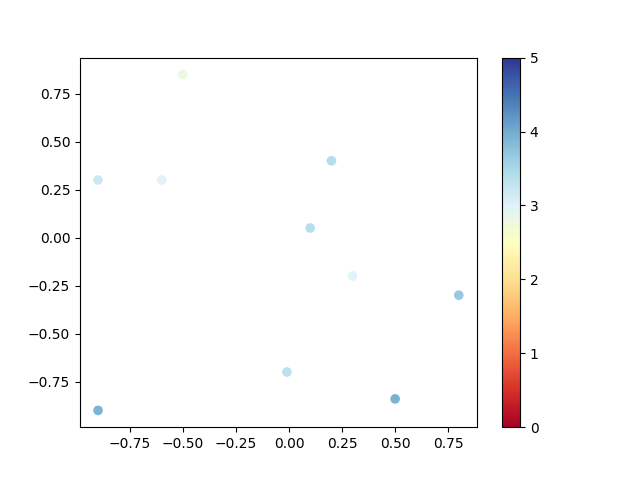

<IPython.core.display.Javascript object>


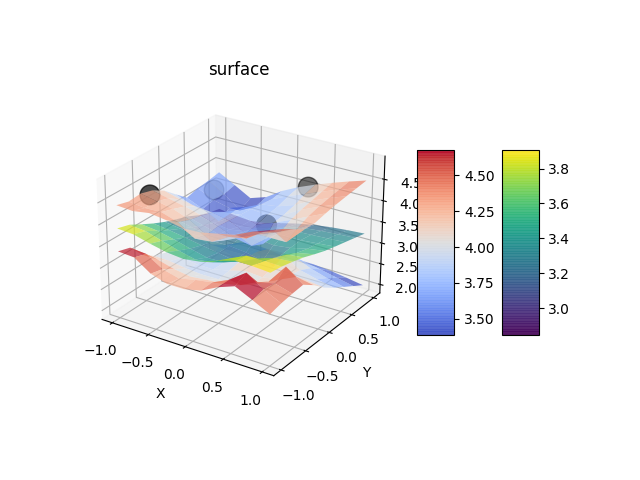

<IPython.core.display.Javascript object>


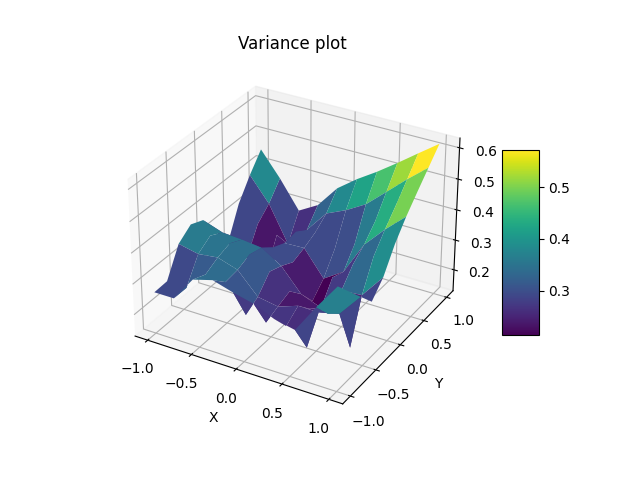

In [79]:
print(np.shape(mean))
# Extracting only the diaginal elements: variance from covariance matrix
var = np.diag(cov).reshape(-1,1)

beta = 2
x_choose = [4.500000000000000111e-01, 7.199999999999999734e-01, -8.000000000000000444e-01, -8.000000000000000444e-01]
y_choose = [6.500000000000000222e-01, -6.400000000000000133e-01, -6.500000000000000222e-01, 5.999999999999999778e-01]
z_choose = []
for i in range(len(x_choose)):
    index = np.argmin(np.linalg.norm(pred_input - np.array([x_choose[i],y_choose[i]]),axis=1))
    z_choose.append( mean.reshape(-1,1)[index] + beta*np.sqrt(var.reshape(-1,1)[index]) + 0.2 )


# converting from list of means to meshgrid format
pred_mean = mean.reshape(-1,1).reshape(num_div,num_div)
pred_var = var.reshape(-1,1).reshape(num_div,num_div)

upper_confidence_layer = pred_mean + beta*np.sqrt(pred_var)
lower_confidence_layer = pred_mean - beta*np.sqrt(pred_var)

# plot original points
plt.figure()
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(train_x_0, train_y_0, c=train_output_0, vmin=0, vmax=5, s=35, cmap=cm)
plt.colorbar(sc)

# z_base = [0, 0, 0, 0]
# z_top = [5.5, 5.5, 5.5, 5.5]
# z_top_cov = [1, 1, 1, 1]

# plotting mesh data
fig = plt.figure()
ax = plt.axes(projection='3d')
p1 = ax.plot_surface(X, Y, pred_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7)
p2 = ax.plot_surface(X, Y, upper_confidence_layer, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none', alpha=0.7)
p3 = ax.plot_surface(X, Y, lower_confidence_layer, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none', alpha=0.7)
    
ax.scatter3D(x_choose, y_choose, z_choose, s=200, c='black')
plt.xlabel('X')
plt.ylabel('Y')
fig.colorbar(p1, shrink=0.5, aspect=5)
fig.colorbar(p2, shrink=0.5, aspect=5)
ax.set_title('surface');

#Plot only the variance
var_layer = np.sqrt(pred_var)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Variance plot')
p1 = ax.plot_surface(X, Y, var_layer, rstride=2, cstride=1,
                cmap='viridis', edgecolor='none')
plt.xlabel('X')
plt.ylabel('Y')
fig.colorbar(p1, shrink=0.5, aspect=5)


In [26]:
15 % 2

1

## Process given data 1

In [80]:
train_x_1 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9, 4.500000000000000111e-01, 7.199999999999999734e-01, -8.000000000000000444e-01, -8.000000000000000444e-01])
train_y_1 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9, 6.500000000000000222e-01, -6.400000000000000133e-01, -6.500000000000000222e-01, 5.999999999999999778e-01])
train_output_1 = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616, 3.368086692765749124e+00, 3.752857874639865532e+00, 3.420476373601408770e+00, 3.040183158829708354e+00]).reshape(-1,1);
train_input_1 = np.concatenate((train_x_1.reshape(-1,1),train_y_1.reshape(-1,1)),axis=1)

# generate test data
num_div = 10
x1 = np.linspace(-1,1,num_div)#.reshape(-1,1)
y1 = np.linspace(-1,1,num_div)#.reshape(-1,1)
X1, Y1 = np.meshgrid(x1,y1)

# converting from meshgrid format to a list of points
pred_input = np.concatenate((X1.reshape(-1,1),Y1.reshape(-1,1)),axis=1)
noise_cov = 0.001
mean_func = lambda x: np.zeros((x.shape[0],1))

kernels, params = train_gp(train_x_1, train_y_1, train_output_1)

RMSE = []
for i in range(np.shape(params)[0]):
    means, covs = gpr(train_input_1, train_output_1, train_input_1, noise_cov * np.ones((train_input_1.shape[0])), mean_func, kernels[i], params[i])
    MSE = np.square(np.subtract(train_output_1,means)).mean() 
    RMSE.append(math.sqrt(MSE))

print("\n RMSEs", RMSE)
best_kernel_index = np.argmin( np.asarray(RMSE) )
kernel = kernels[best_kernel_index]
param = params[best_kernel_index]

print(f"Data 1: kernel: {kernel.__name__}, params:{params}")
mean1, cov1 = gpr(train_input_1, train_output_1, pred_input, noise_cov * np.ones((train_input_1.shape[0])), mean_func, kernel, param)


optimizing kernel : sqexp, initial parameter :[1. 3. 2.]
Optimized parameter for this kernel:  [5.3595648  9.56771102 2.48564549]


optimizing kernel : rational, initial parameter :[1. 1. 1.]
Optimized parameter for this kernel:  [2.03032214 0.87333677 3.38288467]


optimizing kernel : periodic, initial parameter :[1. 1. 1.]
Optimized parameter for this kernel:  [2.0243455  1.90519961 3.16433691]


ALL kernel optimization finished 

Original parameter (negative)likelihoods for all kernels  [106.01918156434576, 16.315828670870168, 25.216735191039085]
Optimized parameter (negative)likelihoods for all kernels [57.94562617416459, 6.850828868529449, 13.478518416122176]

 Make sure that NEW PARAMETERS (negative) likelihood < OLD PARAMETER (negative) likelihood

 RMSEs [0.08671026163341752, 0.003477488009450635, 0.004817798326542971]
Data 1: kernel: rational, params:[array([5.3595648 , 9.56771102, 2.48564549]), array([2.03032214, 0.87333677, 3.38288467]), array([2.0243455 , 1.90519961, 3.1643

### Plot given data 1

[array([4.85027807]), array([3.86805497]), array([4.44685129])]


<IPython.core.display.Javascript object>


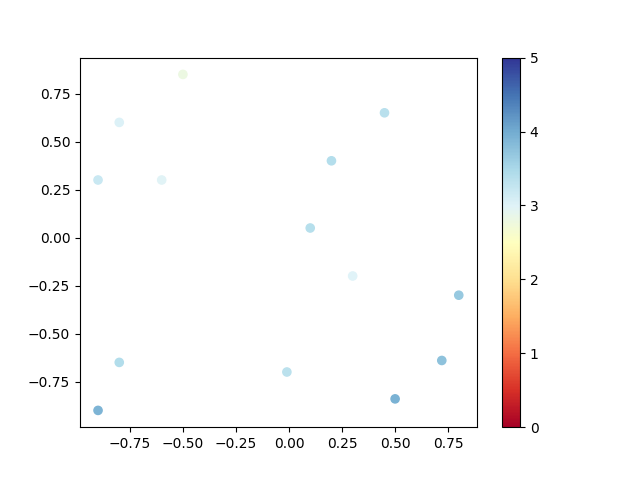

<IPython.core.display.Javascript object>


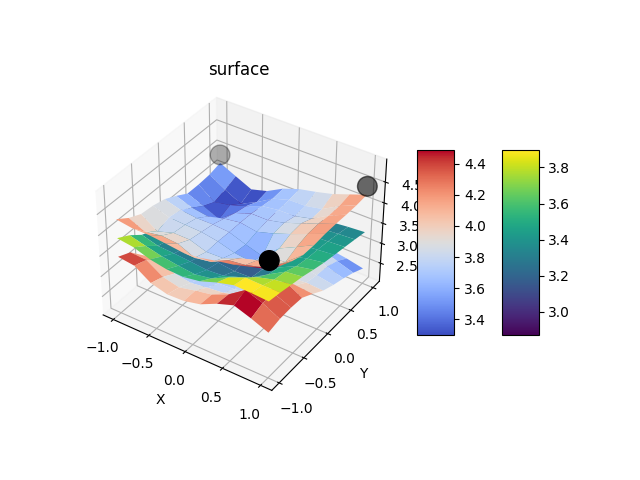

<IPython.core.display.Javascript object>


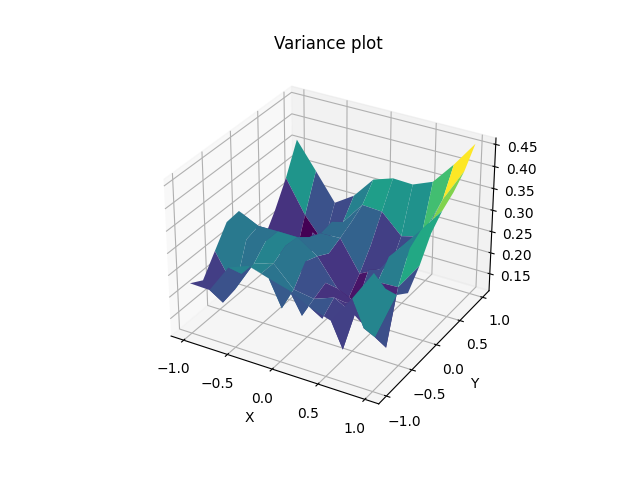

Text(0.5, 0, 'Y')

In [92]:

# Extracting only the diaginal elements: variance from covariance matrix
var1 = np.diag(cov1).reshape(-1,1)

beta = 2
x_choose1 = [ 1.0, -1.0, 1.0]
y_choose1 = [-1.0, 1.0, 1.0]
z_choose1 = []
for i in range(len(x_choose1)):
    index = np.argmin(np.linalg.norm(pred_input - np.array([x_choose1[i],y_choose1[i]]),axis=1))
    z_choose1.append( mean1.reshape(-1,1)[index] + beta*np.sqrt(var1.reshape(-1,1)[index]) + 0.2 )
print(z_choose1)

# converting from list of means to meshgrid format
pred_mean1 = mean1.reshape(-1,1).reshape(num_div,num_div)
pred_var1 = var1.reshape(-1,1).reshape(num_div,num_div)

beta = 2
upper_confidence_layer1 = pred_mean1 + beta*np.sqrt(pred_var1)
lower_confidence_layer1 = pred_mean1 - beta*np.sqrt(pred_var1)

# plot original points
fig = plt.figure()
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(train_x_1, train_y_1, c=train_output_1, vmin=0, vmax=5, s=35, cmap=cm)
fig.colorbar(sc)

# plotting mesh data
fig = plt.figure()
ax = plt.axes(projection='3d')
p1 = ax.plot_surface(X1, Y1, pred_mean1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
p2 = ax.plot_surface(X1, Y1, upper_confidence_layer1, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
p3 = ax.plot_surface(X1, Y1, lower_confidence_layer1, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
fig.colorbar(p1, shrink=0.5, aspect=5)
fig.colorbar(p2, shrink=0.5, aspect=5)
ax.set_title('surface');
plt.xlabel('X')
plt.ylabel('Y')
ax.scatter3D(x_choose1, y_choose1, z_choose1, s=200, c='black')

#Plot only the variance
var_layer1 = np.sqrt(pred_var1)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Variance plot')
p1 = ax.plot_surface(X1, Y1, var_layer1, rstride=2, cstride=1,
                cmap='viridis', edgecolor='none')
plt.xlabel('X')
plt.ylabel('Y')

## Process Given data 2

In [29]:
train_x_2 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9, 4.500000000000000111e-01, 7.199999999999999734e-01, -8.000000000000000444e-01, -8.000000000000000444e-01, 1.0, -1.0, 1.0])
train_y_2 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9, 6.500000000000000222e-01, -6.400000000000000133e-01, -6.500000000000000222e-01, 5.999999999999999778e-01, -1.0, 1.0, 1.0])
train_output_2 = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616, 3.368086692765749124e+00, 3.752857874639865532e+00, 3.420476373601408770e+00, 3.040183158829708354e+00, 4.209100722147459450e+00, 3.138971750723630105e+00, 3.695875639644152333e+00]).reshape(-1,1);
train_input_2 = np.concatenate((train_x_2.reshape(-1,1),train_y_2.reshape(-1,1)),axis=1)

# generate test data
num_div = 10
x2 = np.linspace(-1,1,num_div)#.reshape(-1,1)
y2 = np.linspace(-1,1,num_div)#.reshape(-1,1)
X2, Y2 = np.meshgrid(x2,y2)

# converting from meshgrid format to a list of points
pred_input = np.concatenate((X2.reshape(-1,1),Y2.reshape(-1,1)),axis=1)
noise_cov = 0.001
mean_func = lambda x: np.zeros((x.shape[0],1))

kernels, params = train_gp(train_x_2, train_y_2, train_output_2)

RMSE = []
for i in range(np.shape(params)[0]):
    means, covs = gpr(train_input_2, train_output_2, train_input_2, noise_cov * np.ones((train_input_2.shape[0])), mean_func, kernels[i], params[i])
    MSE = np.square(np.subtract(train_output_2,means)).mean() 
#     print("means", means)
    RMSE.append(math.sqrt(MSE))

print("\n RMSEs", RMSE)
best_kernel_index = np.argmin( np.asarray(RMSE) )
kernel = kernels[best_kernel_index]
param = params[best_kernel_index]

print(f"Data 1: kernel: {kernel.__name__}, params:{params}")
mean2, cov2 = gpr(train_input_2, train_output_2, pred_input, noise_cov * np.ones((train_input_2.shape[0])), mean_func, kernel, param)


optimizing kernel : sqexp, initial parameter :[1. 3. 2.]
Optimized parameter for this kernel:  [7.39082451 9.20842833 7.21792185]


optimizing kernel : rational, initial parameter :[1. 1. 1.]
Optimized parameter for this kernel:  [2.05629338 0.83118076 3.67080608]


optimizing kernel : periodic, initial parameter :[1. 1. 1.]
Optimized parameter for this kernel:  [1.00622759 0.98286425 1.40980794]


ALL kernel optimization finished 

Original parameter (negative)likelihoods for all kernels  [128.01521649738547, 19.373033202935652, 25.649720469638538]
Optimized parameter (negative)likelihoods for all kernels [100.42291374752632, 7.2250229468374165, 18.36315338668752]

 Make sure that NEW PARAMETERS (negative) likelihood < OLD PARAMETER (negative) likelihood

 RMSEs [0.10548802968426652, 0.003585910123277185, 0.0034345367322162505]
Data 1: kernel: periodic, params:[array([7.39082451, 9.20842833, 7.21792185]), array([2.05629338, 0.83118076, 3.67080608]), array([1.00622759, 0.98286425, 1.40

[array([7.16595001]), array([7.34915839]), array([6.29153101]), array([4.56429204]), array([4.58847131])]


<IPython.core.display.Javascript object>


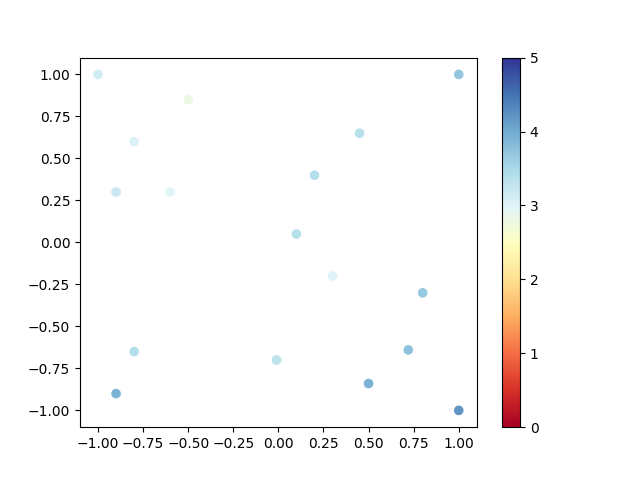

<IPython.core.display.Javascript object>


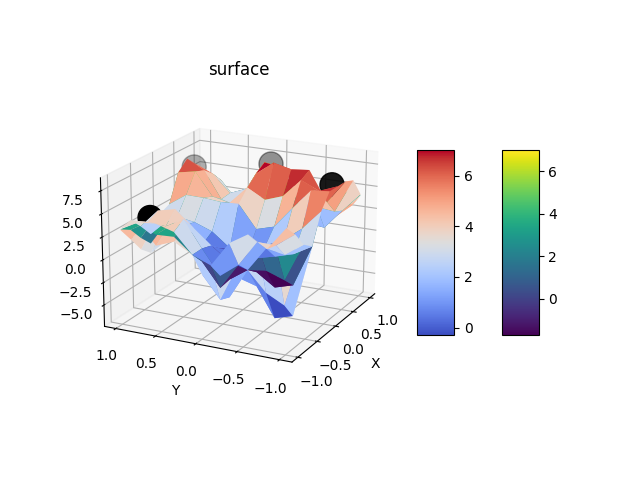

<IPython.core.display.Javascript object>


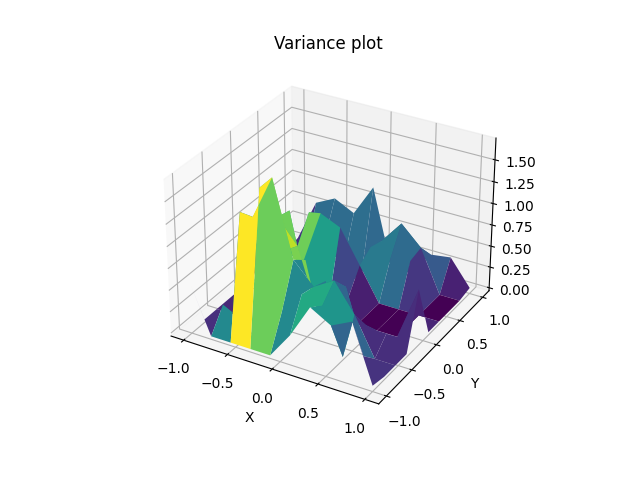

In [99]:

# Extracting only the diaginal elements: variance from covariance matrix
var2 = np.diag(cov2).reshape(-1,1)

beta = 2
x_choose2 = [ 0.72, 0.22, 0.5, 0.7, -0.9]
y_choose2 = [0.0, -0.98, 0.88, -0.23, 0.68]
z_choose2 = []
for i in range(len(x_choose2)):
    index = np.argmin(np.linalg.norm(pred_input - np.array([x_choose2[i],y_choose2[i]]),axis=1))
    z_choose2.append( mean2.reshape(-1,1)[index] + beta*np.sqrt(var2.reshape(-1,1)[index]) + 0.4 )
print(z_choose2)

# converting from list of means to meshgrid format
pred_mean2 = mean2.reshape(-1,1).reshape(num_div,num_div)
pred_var2 = var2.reshape(-1,1).reshape(num_div,num_div)

beta = 2
upper_confidence_layer2 = pred_mean2 + beta*np.sqrt(pred_var2)
lower_confidence_layer2 = pred_mean2 - beta*np.sqrt(pred_var2)

# plot original points
fig = plt.figure()
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(train_x_2, train_y_2, c=train_output_2, vmin=0, vmax=5, s=35, cmap=cm)
fig.colorbar(sc)

# plotting mesh datafig = plt.figure()
fig = plt.figure()
ax = plt.axes(projection='3d')
p1 = ax.plot_surface(X2, Y2, pred_mean2, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
p2 = ax.plot_surface(X2, Y2, upper_confidence_layer2, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
p3 = ax.plot_surface(X2, Y2, lower_confidence_layer2, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
fig.colorbar(p1, shrink=0.5, aspect=5)
fig.colorbar(p2, shrink=0.5, aspect=5)
ax.scatter3D(x_choose2, y_choose2, z_choose2, s=300, c='black')
plt.xlabel('X')
plt.ylabel('Y')
ax.set_title('surface');

#Plot only the variance
var_layer2 = np.sqrt(pred_var2)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Variance plot')
plt.xlabel('X')
plt.ylabel('Y')
p4 = ax.plot_surface(X2, Y2, var_layer2, rstride=2, cstride=1,
                cmap='viridis', edgecolor='none')

## Plot Monte Carlo probabilities over grid cells for Verifying the approach

empirical probabilities [[1. 1. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 0. 1.]]


<IPython.core.display.Javascript object>


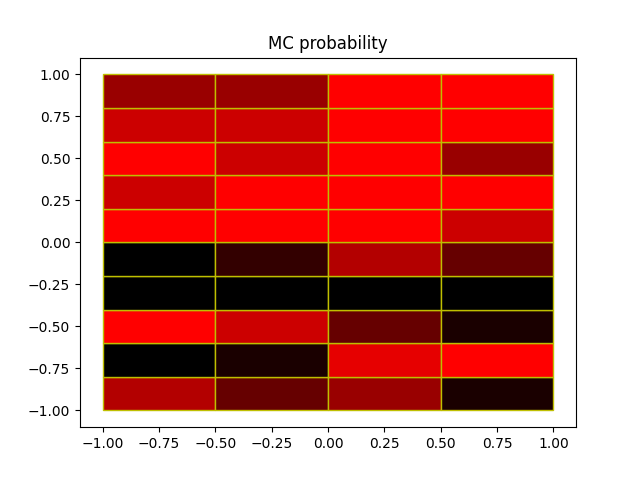

<IPython.core.display.Javascript object>


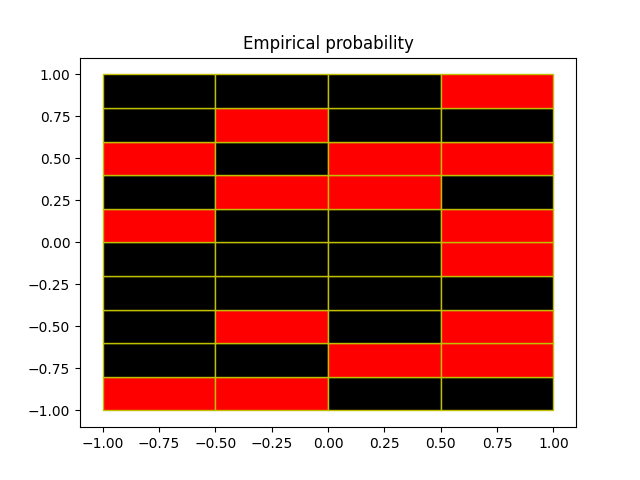

Text(0.5, 1.0, 'Empirical probability')

In [31]:
from matplotlib.patches import Rectangle
# from matplotlib.collections import Patch

threshold = 2.5;
N = 10; # num samples

MC_estimate = np.zeros((4,10));
empirical_estimate = np.zeros((4,10))

xdiv = 4
ydiv = 10
xint = 2.0/xdiv
yint = 2.0/ydiv

for ii in range(xdiv): 
    for jj in range(ydiv):
        
        # Estimated MC probability
        X_test = xint*np.random.random(N) - 1 + ii*xint 
        Y_test = yint*np.random.random(N) - 1 + jj*yint 
    
        test_input = np.concatenate((X_test.reshape(-1,1),Y_test.reshape(-1,1)),axis=1)
        
        sensor_pred_means, sensor_pred_covs = gpr(train_input_2, train_output_2, test_input, noise_cov * np.ones((train_input_2.shape[0])), mean_func, kernel, param)
        sensor_vars = np.diag(sensor_pred_covs).reshape(-1,1)

        beta = 2
        sensor_upper_confidence = sensor_pred_means + beta*np.sqrt(sensor_vars)
        
        MC_estimate[ii,jj] = (sensor_upper_confidence > threshold).sum()/N;
        
        # Empirical probability
        num_points = 0
        for idx, xx in enumerate(train_input_2):
            if xx[0]>=(-1+ii*xint) and xx[0]<=(-1 + xint + ii*xint) and xx[1]>=(-1+jj*yint) and xx[1]<=(-1 + yint+jj*yint):
                num_points = num_points + 1
                if train_output_2[idx]>threshold:
                    empirical_estimate[ii,jj] = empirical_estimate[ii,jj] + 1
        if num_points>0:
            empirical_estimate[ii,jj] = empirical_estimate[ii,jj]/num_points
                
        
print("empirical probabilities", empirical_estimate)


xplot = np.linspace(-1.0,1.0,xdiv+1)[0:-1];
yplot = np.linspace(-1.0,1.0,ydiv+1)[0:-1];
x_grid, y_grid = np.meshgrid(xplot,yplot)

x_grid = x_grid.reshape(-1,1) #np.reshape(x_grid,[],1)
y_grid = y_grid.reshape(-1,1) #reshape(y_grid,[],1)

MC_estimate = MC_estimate.reshape(-1,1)
empirical_estimate = empirical_estimate.reshape(-1,1)

fig, ax = plt.subplots()

# plot each rectangle
plt.plot(-1,-1)
plt.plot(1,1)
plt.plot(-1,1)
plt.plot(1,-1)
for i in range((ii+1)*(jj+1)):
    rect = plt.Rectangle((x_grid[i],y_grid[i]), xint, yint,
                             facecolor=(MC_estimate[i,:][0], 0.0, 0.0), edgecolor='y')
    
    #empirical probability
    ax.add_patch(rect)
plt.title("MC probability")
    
    
# Now get the empirical probability
fig, ax = plt.subplots()

# plot each rectangle
plt.plot(-1,-1)
plt.plot(1,1)
plt.plot(-1,1)
plt.plot(1,-1)
for i in range((ii+1)*(jj+1)):
    rect = plt.Rectangle((x_grid[i],y_grid[i]), xint, yint,
                             facecolor=(empirical_estimate[i,:][0], 0.0, 0.0), edgecolor='y')
    
    #empirical probability
    ax.add_patch(rect)
plt.title("Empirical probability")

## Process given data 3

In [32]:
train_x_3 = np.asarray([0.1, -0.9, 0.2, 0.8 ,-0.6, 0.3, 0.5, -0.5, -0.01, -0.9, 4.500000000000000111e-01, 7.199999999999999734e-01, -8.000000000000000444e-01, -8.000000000000000444e-01, 1.0, -1.0, 1.0, 0.72, 0.22, 0.5, 0.7, -0.9])
train_y_3 = np.asarray([0.05, 0.3, 0.4, -0.3 ,0.3, -0.2 ,-0.84 ,0.85, -0.7, -0.9, 6.500000000000000222e-01, -6.400000000000000133e-01, -6.500000000000000222e-01, 5.999999999999999778e-01, -1.0, 1.0, 1.0, 0.0, -0.98, 0.88, -0.23, 0.68])
train_output_3 = np.asarray([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928 ,2.7968011, 3.34929734, 3.9129616, 3.368086692765749124e+00, 3.752857874639865532e+00, 3.420476373601408770e+00, 3.040183158829708354e+00, 4.209100722147459450e+00, 3.138971750723630105e+00, 3.695875639644152333e+00, 3.539918076589174234e+00, 3.792407412748300288e+00, 3.070353039732824918e+00, 3.437687562351025683e+00, 3.040246578380022324e+00]).reshape(-1,1);
train_input_3 = np.concatenate((train_x_3.reshape(-1,1),train_y_3.reshape(-1,1)),axis=1)

# generate test data
num_div = 50
x3 = np.linspace(-1,1,num_div)#.reshape(-1,1)
y3 = np.linspace(-1,1,num_div)#.reshape(-1,1)
X3, Y3 = np.meshgrid(x3,y3)

# converting from meshgrid format to a list of points
pred_input = np.concatenate((X3.reshape(-1,1),Y3.reshape(-1,1)),axis=1)
noise_cov = 0.001
mean_func = lambda x: np.zeros((x.shape[0],1))

kernels, params = train_gp(train_x_3, train_y_3, train_output_3)

RMSE = []
for i in range(np.shape(params)[0]):
    means, covs = gpr(train_input_3, train_output_3, train_input_3, noise_cov * np.ones((train_input_3.shape[0])), mean_func, kernels[i], params[i])
    MSE = np.square(np.subtract(train_output_3,means)).mean() 
#     print("means", means)
    RMSE.append(math.sqrt(MSE))

print("\n RMSEs", RMSE)
best_kernel_index = np.argmin( np.asarray(RMSE) )
kernel = kernels[best_kernel_index]
param = params[best_kernel_index]

print(f"Data 1: kernel: {kernel.__name__}, params:{params}")
mean3, cov3 = gpr(train_input_3, train_output_3, pred_input, noise_cov * np.ones((train_input_3.shape[0])), mean_func, kernel, param)


optimizing kernel : sqexp, initial parameter :[1. 3. 2.]
Optimized parameter for this kernel:  [ 8.29091287 13.81220821 10.71682086]


optimizing kernel : rational, initial parameter :[1. 1. 1.]
Optimized parameter for this kernel:  [2.02861826 0.87025674 3.89422395]


optimizing kernel : periodic, initial parameter :[1. 1. 1.]
Optimized parameter for this kernel:  [1.1639961  2.20599061 2.37901207]


ALL kernel optimization finished 

Original parameter (negative)likelihoods for all kernels  [154.35979949278453, 19.318527361894688, 29.410595780192164]
Optimized parameter (negative)likelihoods for all kernels [145.01079618500552, 4.971798705541046, 28.140969870347465]

 Make sure that NEW PARAMETERS (negative) likelihood < OLD PARAMETER (negative) likelihood

 RMSEs [0.11638773633323729, 0.004172432721790219, 0.010476679473924024]
Data 1: kernel: rational, params:[array([ 8.29091287, 13.81220821, 10.71682086]), array([2.02861826, 0.87025674, 3.89422395]), array([1.1639961 , 2.20599061,

<IPython.core.display.Javascript object>


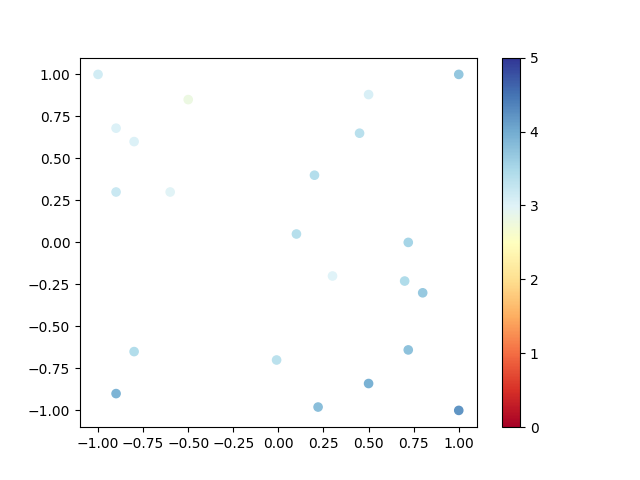

<IPython.core.display.Javascript object>


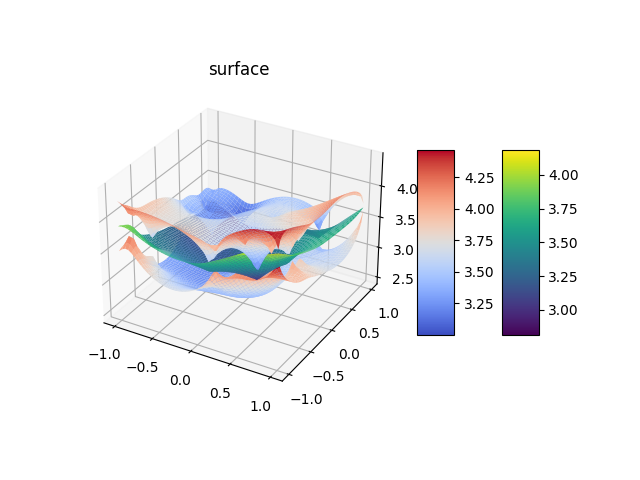

<IPython.core.display.Javascript object>


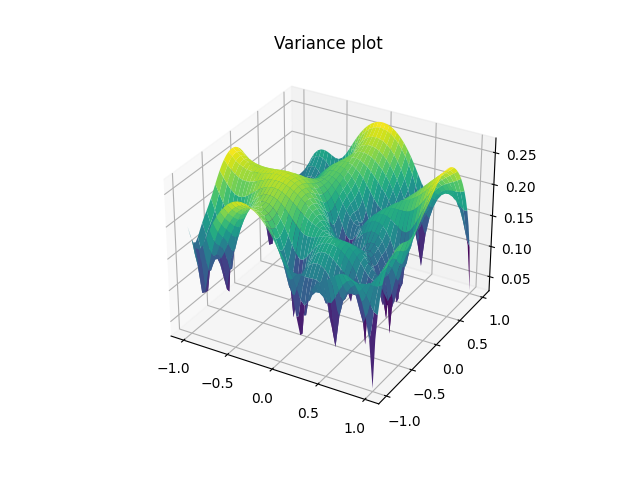

In [33]:

# Extracting only the diaginal elements: variance from covariance matrix
var3 = np.diag(cov3).reshape(-1,1)

# converting from list of means to meshgrid format
pred_mean3 = mean3.reshape(-1,1).reshape(num_div,num_div)
pred_var3 = var3.reshape(-1,1).reshape(num_div,num_div)

beta = 2
upper_confidence_layer3 = pred_mean3 + beta*np.sqrt(pred_var3)
lower_confidence_layer3 = pred_mean3 - beta*np.sqrt(pred_var3)

# plot original points
fig = plt.figure()
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(train_x_3, train_y_3, c=train_output_3, vmin=0, vmax=5, s=35, cmap=cm)
fig.colorbar(sc)

# plotting mesh datafig = plt.figure()
fig = plt.figure()
ax = plt.axes(projection='3d')
p1 = ax.plot_surface(X3, Y3, pred_mean3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
p2 = ax.plot_surface(X3, Y3, upper_confidence_layer3, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
p3 = ax.plot_surface(X3, Y3, lower_confidence_layer3, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none')
fig.colorbar(p1, shrink=0.5, aspect=5)
fig.colorbar(p2, shrink=0.5, aspect=5)
ax.set_title('surface');

#Plot only the variance
var_layer3 = np.sqrt(pred_var3)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Variance plot')
p4 = ax.plot_surface(X3, Y3, var_layer3, rstride=2, cstride=1,
                cmap='viridis', edgecolor='none')